In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

from keras.models import Sequential
from keras.layers import Dense

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold

#import statsmodels.api as sm,

import seaborn as sns; sns.set()

from pandas.core import datetools
%matplotlib inline

import pickle


Using TensorFlow backend.


# Data Acquisition
The following code imports and validates the LendingClub data.

In [2]:
df = pickle.load(open("sub_data.p",'rb'))
mature_filter = (df['loan_status']=='Fully Paid')|(df['loan_status']=='Charged Off')
df = df[mature_filter]

In [3]:
has_data = {}
for column in df.columns:
    has_data[column] = len(df[column].dropna())

order_has_data=sorted(has_data, key=lambda dict_key: has_data[dict_key])

In [4]:
# Convert dates to datetime
df['issue_d'] = pd.to_datetime(df['issue_d'])
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'])

#determine age of credit line prior to loan issue and convert to integer
# days of credit history
df['earliest_cr_line'] = (df['issue_d']-df['earliest_cr_line']).dt.days

# convert issue_d to a year to consider economic conditions
#SHOULD WE GO TO QUARTERS?
df['issue_d'] = df['issue_d'].dt.year

In [5]:
# Limit to loans that are paid in full or written off. Uses dates so that 
# loans that are delinquent are not disproportionaltely dropped from data

mature_filter = (df['loan_status']=='Fully Paid')|(df['loan_status']=='Charged Off')
#latest_mature = df[~mature_filter]['issue_d'].min()
#latest_mature
#reduced_df = df[df['issue_d']<=latest_mature]
reduced_df = df[mature_filter] # Pulls only loans that are charged off or paid in full.
#
## Use my documentation to filter to only 
data_dict = pd.read_excel('./Source Data/LCDataDictionary.xlsx',sheet_name='LoanStats')
features = list(data_dict[data_dict['Useful Predictor']=='Yes']['LoanStatNew'].values)
reduced_df=reduced_df[features]

# Combines fields when necessary
reduced_df['fico_est'] = (reduced_df['fico_range_low']+reduced_df['fico_range_high'])/2

reduced_df.drop(columns=['fico_range_low','fico_range_high'],inplace=True)
print(reduced_df.shape)

(102069, 69)


In [6]:
# Convert strings to numbers emp_length, int_rate, revol_util
emp_length_map={'10+ years':10, '< 1 year':0, '1 year':1, '3 years':3, '8 years':8, '9 years':9,
                '4 years':4, '5 years':5, '6 years':6, '2 years':2, '7 years':7}

reduced_df['emp_length']=reduced_df['emp_length'].replace(pd.Series(emp_length_map))

grade_map={"A":1,"B":2,"C":3,"D":4,"E":5,"F":6,"G":7}
reduced_df['grade']=reduced_df['grade'].replace(pd.Series(grade_map))

reduced_df['int_rate']=reduced_df['int_rate'].apply(lambda x: float(x[:-1]))
reduced_df['revol_util']=reduced_df['revol_util'].apply(lambda x:
                                                        x[:-1] if isinstance(x, str) else np.nan).astype(float)

reduced_df['earliest_cr_line']=reduced_df['earliest_cr_line'].apply(lambda x:
                                                        0.0 if np.isnan(x) else x)

reduced_df.drop(columns=['emp_title'],inplace=True)

print(reduced_df.shape)

(102069, 68)


# Which values are categorical?

In [7]:
n_options = {}
for column in reduced_df.columns:
    n_options[column] = len(reduced_df[column].unique())
#n_options
order_n_options=sorted(n_options, key=lambda dict_key: n_options[dict_key])

for i in order_n_options[0:50]:
    print(i, n_options[i],reduced_df[i].unique())

application_type 2 ['Individual' 'Joint App']
term 2 [' 36 months' ' 60 months']
verification_status 3 ['Verified' 'Source Verified' 'Not Verified']
chargeoff_within_12_mths 6 [ 0.  1.  2.  3.  4. nan]
home_ownership 6 ['MORTGAGE' 'OWN' 'RENT' 'ANY' 'NONE' 'OTHER']
grade 7 [1 2 5 4 3 7 6]
collections_12_mths_ex_med 8 [ 0.  1.  2.  3.  4.  5. nan 12.]
inq_last_6mths 9 [2. 1. 0. 3. 5. 4. 6. 8. 7.]
pub_rec_bankruptcies 9 [ 0.  1.  2.  3. nan  4.  5.  6.  7.]
emp_length 12 [ 0. nan 10.  2.  7.  8.  3.  1.  6.  9.  5.  4.]
issue_d 12 [2015 2014 2012 2016 2017 2013 2018 2009 2010 2011 2008 2007]
open_il_12m 13 [nan  2.  0.  1.  4.  3.  6.  5. 14.  9. 10.  7.  8.]
purpose 14 ['credit_card' 'debt_consolidation' 'home_improvement' 'small_business'
 'other' 'car' 'moving' 'major_purchase' 'medical' 'vacation' 'house'
 'educational' 'wedding' 'renewable_energy']
tax_liens 16 [ 0.  2.  1.  4.  3.  5.  6.  7. 12.  8. 18. 15.  9. 11. 45. nan]
open_acc_6m 17 [nan  3.  0.  2.  1.  5.  4.  6. 10.  9.  

Based on these results, we will have to encode several data as dummy variables:

- application_type
- term
- verification_status
- home_ownership
- purpose


## Additional Multicolinearity Analysis
I performed some additional analysis on multicolinearity. Some of the dummy variables were over 7,000. The reason being is the one hot encoding is dropping the first thing it encounters. In some cases there are only 1 or two instances of it. Therefore, there is some repetition in dummy variables. As a solution, I tried using only one of the possible answers.

In [8]:
for p in reduced_df['purpose'].unique():
    print(p, len(df[df['purpose']==p]))

credit_card 22313
debt_consolidation 59915
home_improvement 6356
small_business 1182
other 5548
car 1147
moving 719
major_purchase 2219
medical 1131
vacation 698
house 496
educational 35
wedding 230
renewable_energy 80


In [9]:
# Consolidated where logical
reduced_df['purpose'].replace('credit_card','debt_consolidation',inplace=True)
reduced_df['purpose'].replace('educational','other',inplace=True)
reduced_df['purpose'].replace('wedding','major_purchase',inplace=True)
reduced_df['purpose'].replace('vacation','major_purchase',inplace=True)
reduced_df['purpose'].replace('moving','house',inplace=True)
reduced_df['purpose'].replace('home_improvement ','house',inplace=True)
reduced_df['purpose'].replace('renewable_energy ','house',inplace=True)

In [10]:
seta=set(reduced_df.columns)


# 8/8 consolidated purpose

reduced_df=pd.get_dummies(data=reduced_df,columns=['application_type','term',
                                                   'verification_status','purpose'],
                          drop_first=True)

# 8/8 removed 'home_ownership
reduced_df['home_ownership'] = np.where(reduced_df['home_ownership']=='OWN',1,0)

setb=set(reduced_df.columns)
print(setb-seta)
print(reduced_df.shape)

{'purpose_major_purchase', 'term_ 60 months', 'purpose_renewable_energy', 'purpose_debt_consolidation', 'purpose_other', 'purpose_home_improvement', 'purpose_house', 'verification_status_Verified', 'verification_status_Source Verified', 'purpose_small_business', 'purpose_medical', 'application_type_Joint App'}
(102069, 76)


# How to treat NaN?

For now, let's remove majority NaN columns...

In [11]:
has_data = {}
for column in reduced_df.columns:
    has_data[column] = len(reduced_df[column].dropna())
has_data

order_has_data=sorted(has_data, key=lambda dict_key: has_data[dict_key])

top_sparse=25
for i,j in zip(range(top_sparse),order_has_data[0:top_sparse]):
    print(i,j, has_data[j])

0 annual_inc_joint 940
1 dti_joint 940
2 mths_since_last_record 17208
3 mths_since_recent_bc_dlq 24010
4 mths_since_last_major_derog 26492
5 mths_since_rcnt_il 28765
6 all_util 29451
7 inq_fi 29454
8 inq_last_12m 29454
9 open_acc_6m 29454
10 open_il_12m 29454
11 open_il_24m 29454
12 open_rv_12m 29454
13 open_rv_24m 29454
14 total_cu_tl 29454
15 mths_since_recent_revol_delinq 33581
16 mths_since_last_delinq 50173
17 mths_since_recent_inq 87988
18 mo_sin_old_il_acct 92446
19 mo_sin_old_rev_tl_op 95277
20 mo_sin_rcnt_rev_tl_op 95277
21 mo_sin_rcnt_tl 95278
22 num_accts_ever_120_pd 95278
23 num_bc_tl 95278
24 num_il_tl 95278


In [12]:
nonnan_df=reduced_df.drop(columns=order_has_data[0:19])
print(nonnan_df.shape)

(102069, 57)


In [13]:
print(len(reduced_df.dropna()),len(nonnan_df.dropna()))
nonnan_df=nonnan_df.dropna()
print(nonnan_df.shape)

n_options = {}
for column in nonnan_df.columns:
    n_options[column] = len(nonnan_df[column].unique())
#n_options
order_n_options=sorted(n_options, key=lambda dict_key: n_options[dict_key])


19 88994
(88994, 57)


In [14]:
revolving = [
    'bc_open_to_buy',
    'num_rev_accts',
    'num_rev_tl_bal_gt_0',
    'revol_bal',
    'revol_util',
    'total_rev_hi_lim',
    'tot_hi_cred_lim',
    'num_il_tl',
    'open_acc',
    'num_bc_tl',
    'num_sats',
    'num_op_rev_tl',
    'num_bc_sats',
    'mo_sin_old_rev_tl_op',
    'total_il_high_credit_limit'
]

to_remove = revolving.copy()
to_remove += ['grade'] # Extra code to drop grade

# Additional factors to remove
if 'installment' not in to_remove:
    to_remove += ['installment']
to_remove += ['total_pymnt','loan_amnt']
   
    
features = list(set(nonnan_df.columns) - set(to_remove))

nonnan_df['percent_of_income'] = nonnan_df['installment']*12/nonnan_df['annual_inc']
nonnan_df['percent_of_income'].describe()

count    88994.000000
mean         0.078956
std          0.049376
min          0.000204
25%          0.046985
50%          0.072803
75%          0.104707
max          4.216600
Name: percent_of_income, dtype: float64

# Let's work with training and test sets

In [15]:
print(df.shape,nonnan_df.shape)

# need to look at interest rate as well!!!
y=nonnan_df['total_pymnt']/(nonnan_df['installment']*36 + nonnan_df['installment']*nonnan_df['term_ 60 months']*24)
#y=nonnan_df['total_pymnt']/nonnan_df['loan_amnt']
print(features)
traintest_df=nonnan_df[features]

X_train, X_test, y_train, y_test = train_test_split(
    traintest_df,y,test_size=0.2,random_state=42)#,stratify=nonnan_df[['loan_status']])

Xscaler = StandardScaler()
Xscaler.fit_transform(X_train,X_test)

print(X_train.shape,X_test.shape)

(102069, 153) (88994, 58)
['issue_d', 'mths_since_recent_bc', 'inq_last_6mths', 'int_rate', 'mort_acc', 'term_ 60 months', 'purpose_major_purchase', 'pub_rec_bankruptcies', 'home_ownership', 'earliest_cr_line', 'purpose_debt_consolidation', 'purpose_home_improvement', 'purpose_other', 'num_tl_90g_dpd_24m', 'total_bal_ex_mort', 'tot_coll_amt', 'purpose_medical', 'chargeoff_within_12_mths', 'annual_inc', 'purpose_renewable_energy', 'dti', 'mo_sin_rcnt_tl', 'num_tl_op_past_12m', 'fico_est', 'emp_length', 'verification_status_Verified', 'verification_status_Source Verified', 'tax_liens', 'pub_rec', 'mo_sin_rcnt_rev_tl_op', 'percent_bc_gt_75', 'collections_12_mths_ex_med', 'purpose_house', 'delinq_2yrs', 'purpose_small_business', 'application_type_Joint App', 'num_accts_ever_120_pd', 'total_bc_limit']
(71195, 38) (17799, 38)


In [16]:
# your code here

pca = PCA(n_components=.95,svd_solver="full")
principalComponents = pca.fit(X_train)

print("PCA used %d components to capture >95%% variance."% len(pca.components_))
print("Total variance captured = %f." % pca.explained_variance_ratio_.sum())
#print(principalComponents.components_)

X_pca_train = pca.transform(X_train)
X_pca_test = pca.transform(X_test)


PCA used 3 components to capture >95% variance.
Total variance captured = 0.999345.


In [17]:
LCOLSModel = LinearRegression().fit(X_train, y_train)

print(LCOLSModel.intercept_)
print(LCOLSModel.coef_)

# your code here
trainR2 = r2_score(y_train,LCOLSModel.predict(X_train))

testR2 = r2_score(y_test,LCOLSModel.predict(X_test))

print("The training set OLS regression R^2 score is: %f" % trainR2)
print("The test set OLS regression R^2 score is: %f" % testR2)

-5.992964322360924
[ 4.50594596e-03  1.94419070e-04 -5.94881932e-03 -1.39306914e-02
  4.85627011e-03 -1.39204368e-01 -1.50432176e-02  1.91650287e-03
  1.41114258e-04 -1.28172093e-04 -9.40989186e-03 -1.03128395e-02
 -1.67308701e-04 -6.61058657e-04  5.99996852e-08  6.94452534e-07
 -1.80447321e-02  6.98101735e-03  1.29746037e-08 -3.82847911e-03
 -1.15044973e-03  4.58706575e-05 -3.85033938e-03  1.37822635e-04
  1.13049906e-03 -1.09867858e-02 -8.54477008e-03  2.63204466e-04
  1.18311212e-03 -8.50317535e-05 -3.97635570e-05 -1.16996298e-02
 -1.15769488e-02 -1.35754417e-03 -4.06818184e-02  2.95760028e-02
  1.07984147e-03  6.37458302e-08]
The training set OLS regression R^2 score is: 0.256537
The test set OLS regression R^2 score is: 0.255281


In [18]:
lambdas = [.001, .005, 1, 5, 10, 50, 100, 500, 1000]

kfold = KFold(5, shuffle=True) # use this for testing

LCRRModel = RidgeCV(alphas=lambdas, cv=kfold)
LCRRModel.fit(X_train, y_train)
LCRR_shrinkage_parameter=LCRRModel.alpha_

print("Best model searched:\nalpha = {}\nintercept = {}\nbetas = {}, ".format(LCRR_shrinkage_parameter,
                                                                            LCRRModel.intercept_,
                                                                            LCRRModel.coef_
                                                                            )
     )

RRtrainR2 = r2_score(y_train,LCRRModel.predict(X_train))
RRtestR2 = r2_score(y_test,LCRRModel.predict(X_test))
print("The training set Ridge regression R^2 score is: %f" % RRtrainR2)
print("The test set Ridge regression R^2 score is: %f" % RRtestR2)

Best model searched:
alpha = 100
intercept = -5.892840126666229
betas = [ 4.45217559e-03  1.93821657e-04 -5.89162402e-03 -1.40205730e-02
  4.83525052e-03 -1.37714253e-01 -7.48025743e-03  1.83724021e-03
  1.74085776e-04 -1.27922174e-04 -2.39592258e-03 -3.12926827e-03
  6.93183495e-03 -6.55392875e-04  5.89838194e-08  6.88134901e-07
 -9.45634607e-03  6.07566545e-03  1.22968089e-08  1.15418993e-03
 -1.14451634e-03  4.63635617e-05 -3.82175623e-03  1.34812362e-04
  1.12011773e-03 -1.09168122e-02 -8.56934937e-03  2.01787023e-04
  1.21934060e-03 -8.47909375e-05 -3.84763914e-05 -1.09717164e-02
 -3.70823209e-03 -1.34000116e-03 -2.89662720e-02  2.54484880e-02
  1.07787799e-03  6.05487935e-08], 
The training set Ridge regression R^2 score is: 0.256518
The test set Ridge regression R^2 score is: 0.255231


In [19]:
LCLRModel = LassoCV(alphas=lambdas, cv=kfold)
LCLRModel.fit(X_train, y_train)
LCLR_shrinkage_parameter = LCLRModel.alpha_
print("Best model searched:\nalpha = {}\nintercept = {}\nbetas = {}, ".format(LCLR_shrinkage_parameter,
                                                                            LCLRModel.intercept_,
                                                                            LCLRModel.coef_
                                                                            )
     )

LRtrainR2 = r2_score(y_train,LCLRModel.predict(X_train))
LRtestR2 = r2_score(y_test,LCLRModel.predict(X_test))
print("The training set Lasso regression R^2 score is: %f" % LRtrainR2)
print("The test set Lasso regression R^2 score is: %f" % LRtestR2)

Best model searched:
alpha = 0.001
intercept = 2.8600091786978923
betas = [ 0.00000000e+00  1.86914248e-04 -4.65713162e-03 -1.45469006e-02
  4.49206837e-03 -1.32216465e-01 -0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.14831635e-04 -0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  5.22719773e-08  7.02592557e-07
 -0.00000000e+00  0.00000000e+00  3.41224829e-09  0.00000000e+00
 -1.12009892e-03  3.68796670e-05 -3.53572884e-03  1.33096510e-04
  1.05095215e-03 -8.75672580e-04 -0.00000000e+00  0.00000000e+00
  0.00000000e+00 -6.21460910e-05 -2.91322817e-05 -0.00000000e+00
 -0.00000000e+00 -3.34677224e-06 -0.00000000e+00  0.00000000e+00
  1.86103124e-04  2.86660060e-08], 
The training set Lasso regression R^2 score is: 0.255566
The test set Lasso regression R^2 score is: 0.254431


In [20]:
coef_df=pd.DataFrame(np.array([X_train.columns,
                               LCOLSModel.coef_,
                               LCRRModel.coef_,
                               LCLRModel.coef_]).T,columns=["feature","OLS","RR","LR"])

In [21]:
print(coef_df)

                                feature          OLS           RR           LR
0                               issue_d   0.00450595   0.00445218            0
1                  mths_since_recent_bc  0.000194419  0.000193822  0.000186914
2                        inq_last_6mths  -0.00594882  -0.00589162  -0.00465713
3                              int_rate   -0.0139307   -0.0140206   -0.0145469
4                              mort_acc   0.00485627   0.00483525   0.00449207
5                       term_ 60 months    -0.139204    -0.137714    -0.132216
6                purpose_major_purchase   -0.0150432  -0.00748026           -0
7                  pub_rec_bankruptcies    0.0019165   0.00183724            0
8                        home_ownership  0.000141114  0.000174086            0
9                      earliest_cr_line -0.000128172 -0.000127922 -0.000114832
10           purpose_debt_consolidation  -0.00940989  -0.00239592           -0
11             purpose_home_improvement   -0.0103128

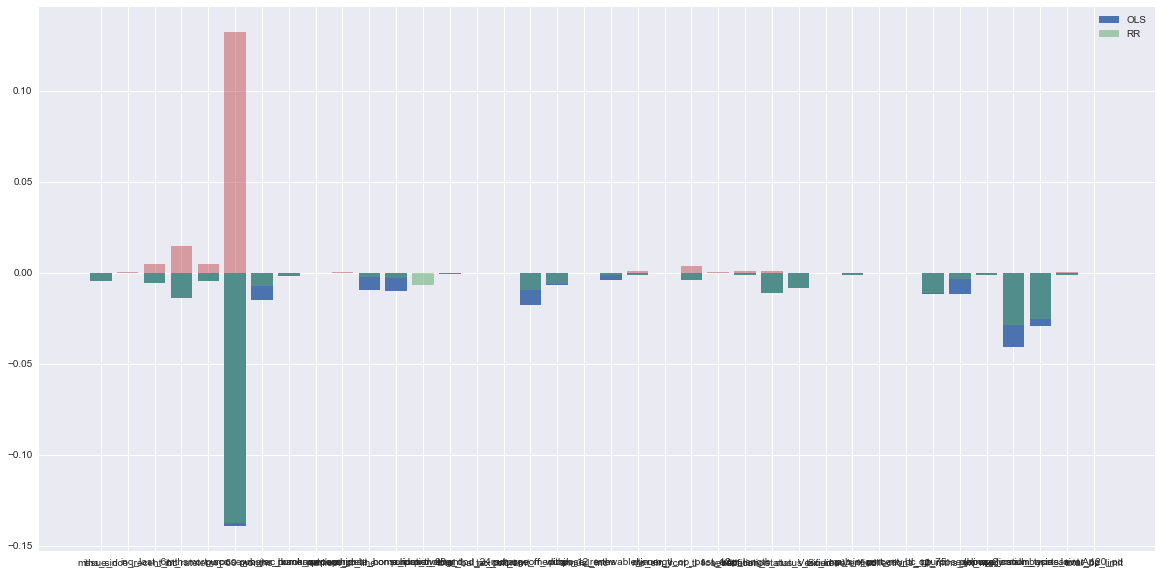

In [22]:
# your code here
plt.figure(figsize=(20,10))
plt.bar(coef_df["feature"],[-abs(x) for x in coef_df["OLS"].values],label='OLS',alpha=1.0)
plt.bar(coef_df["feature"],[-abs(x) for x in coef_df["RR"].values],label='RR',alpha=0.5)
plt.bar(coef_df["feature"],[abs(x) for x in coef_df["LR"].values],alpha=0.5)
plt.yscale("linear")

plt.legend()
plt.show()

In [23]:
size = []
avg_score = []
sd_score = []
for i in range(3,15):
    s = i * 4
    RF_model = RandomForestRegressor(s)
    cv = cross_val_score(RF_model,X_train,y_train,cv=6)
    size += [s]
    avg_score +=  [np.average(cv)]
    sd_score += [np.std(cv)]
    print(i,'complete')
    

3 complete
4 complete
5 complete
6 complete
7 complete
8 complete
9 complete
10 complete
11 complete
12 complete
13 complete
14 complete


Text(0,0.5,'$R^2$ from cross validation')

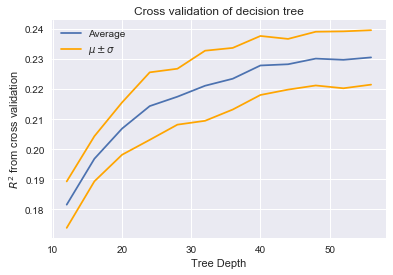

In [24]:
plt.plot(size,avg_score)
bound = []
for i in range(len(size)):
    bound += [avg_score[i]+sd_score[i]]
plt.plot(size,bound,c='orange')

bound = []
for i in range(len(size)):
    bound += [avg_score[i]-sd_score[i]]
plt.plot(size,bound,c='orange')
plt.legend(['Average','$\mu\pm\sigma$'])
plt.title('Cross validation of decision tree')
plt.xlabel('Tree Depth')
plt.ylabel('$R^2$ from cross validation')


In [25]:
cat_preds = pickle.load(open("pred_for_final.pkl",'rb'))

In [26]:
tdf = pd.concat([nonnan_df,cat_preds],axis=1).dropna()


y=tdf['total_pymnt']/(tdf['installment']*36 + tdf['installment']*tdf['term_ 60 months']*24)
#y=nonnan_df['total_pymnt']/nonnan_df['loan_amnt']

features += list(cat_preds.columns)

traintest_df=tdf[features]

X_train, X_test, y_train, y_test = train_test_split(
    traintest_df,y,test_size=0.2,random_state=42)#,stratify=nonnan_df[['loan_status']])

Xscaler = StandardScaler()
Xscaler.fit_transform(X_train,X_test)

print(X_train.shape,X_test.shape)

(70563, 42) (17641, 42)


In [ ]:
size = []
avg_score = []
sd_score = []
for i in range(3,15):
    s = i * 4
    RF_model = RandomForestRegressor(s)
    cv = cross_val_score(RF_model,X_train,y_train,cv=6)
    size += [s]
    avg_score +=  [np.average(cv)]
    sd_score += [np.std(cv)]
    print(i,'complete')
    print('mean' , np.average(cv))

3 complete
mean 0.18335627193485507
4 complete
mean 0.1973090681534405
5 complete
mean 0.20637959730541922
6 complete
mean 0.2141699568510873
7 complete
mean 0.217742837975182
8 complete
mean 0.22231826582236147


In [ ]:
plt.plot(size,avg_score)
bound = []
for i in range(len(size)):
    bound += [avg_score[i]+sd_score[i]]
plt.plot(size,bound,c='orange')

bound = []
for i in range(len(size)):
    bound += [avg_score[i]-sd_score[i]]
plt.plot(size,bound,c='orange')
plt.legend(['Average','$\mu\pm\sigma$'])
plt.title('Cross validation of decision tree')
plt.xlabel('Tree Depth')
plt.ylabel('$R^2$ from cross validation')

Our ridge outperforms the Random forest.

In [ ]:
lambdas = [.001, .005, 1, 5, 10, 50, 100, 500, 1000]

kfold = KFold(5, shuffle=True) # use this for testing

LCRRModel = RidgeCV(alphas=lambdas, cv=kfold)
LCRRModel.fit(X_train, y_train)
LCRR_shrinkage_parameter=LCRRModel.alpha_

print("Best model searched:\nalpha = {}\nintercept = {}\nbetas = {}, ".format(LCRR_shrinkage_parameter,
                                                                            LCRRModel.intercept_,
                                                                            LCRRModel.coef_
                                                                            )
     )

RRtrainR2 = r2_score(y_train,LCRRModel.predict(X_train))
RRtestR2 = r2_score(y_test,LCRRModel.predict(X_test))
print("The training set Ridge regression R^2 score is: %f" % RRtrainR2)
print("The test set Ridge regression R^2 score is: %f" % RRtestR2)

In [ ]:
LCRRModel.predict(X_test)

In [ ]:
y_hat = LCRRModel.predict(X_test)
resid = y_hat - y_test
plt.scatter(y_hat,resid,marker='.',alpha=.5)